In [1]:
import sys
sys.path.append("../")
from dotenv import load_dotenv
load_dotenv("/Users/vigil/Desktop/Vigil/autoredteam/autoredteam/.env")

True

In [2]:
from autoredteam.agents.octo import OctoAPI
agent = OctoAPI(name = "mistral-7b-instruct-fp16", generations=2)

Loading OctoAI Agent: mistral-7b-instruct-fp16


In [19]:
from autoredteam.harnesses.dimension import SecurityHarness, ToxicityHarness, PrivacyHarness, HallucinationHarness, RobustnessHarness, ToxicityHarness, StereotypeHarness, FairnessHarness, EthicsHarness
harnesses = [SecurityHarness, ToxicityHarness, PrivacyHarness, HallucinationHarness, RobustnessHarness, ToxicityHarness, StereotypeHarness, FairnessHarness, EthicsHarness]
harness_instances = [harness(agent) for harness in harnesses]

In [22]:
import json

def write_harness_data(harnesses, md_file='output.md', json_file='output.json'):
    # Initialize a list to store the data for the JSON file
    json_data = []

    # Open the Markdown file
    with open(md_file, 'w') as f:
        # Write the table headers
        f.write('| Harness | Test | Probe Name | Detectors |\n')
        f.write('|---------|------|------------|-----------|\n')

        # Iterate over the harnesses
        for harness in harnesses:
            # Iterate over the test instances in the harness
            for test in harness.test_instances:
               # Get the tags, probe name, and detectors
                tags = ', '.join([tag.split(':')[-1] for tag in harness.tags])
                probe_name = test.probe.probename
                detectors = ', '.join([str(detector) for detector in test.detectors])

                # Extract the desired parts from the string representations
                test_name = '.'.join(str(test).split('.')[-2:-1])
                probe_name = '.'.join(probe_name.split('.')[-2:])
                detectors = ', '.join(['.'.join(detector.split('.')[-2:]) for detector in detectors.split(', ')])

                # Remove the 'object at 0x...>' part from the strings
                test_name = test_name.split(' object at ')[0]
                probe_name = probe_name.split(' object at ')[0]
                detectors = ', '.join([detector.split(' object at ')[0] for detector in detectors.split(', ')])

                # Write the data to the Markdown file
                f.write(f'| {tags} | {test_name} | {probe_name} | {detectors} |\n')

                # Add the data to the list for the JSON file
                json_data.append({
                    'Harness': tags,
                    'Test': test_name,
                    'Probe Name': probe_name,
                    'Detectors': detectors
                })

    # Write the data to the JSON file
    with open(json_file, 'w') as f:
        json.dump(json_data, f, indent=4)

In [23]:
write_harness_data(harness_instances, md_file='output.md', json_file='output.json')

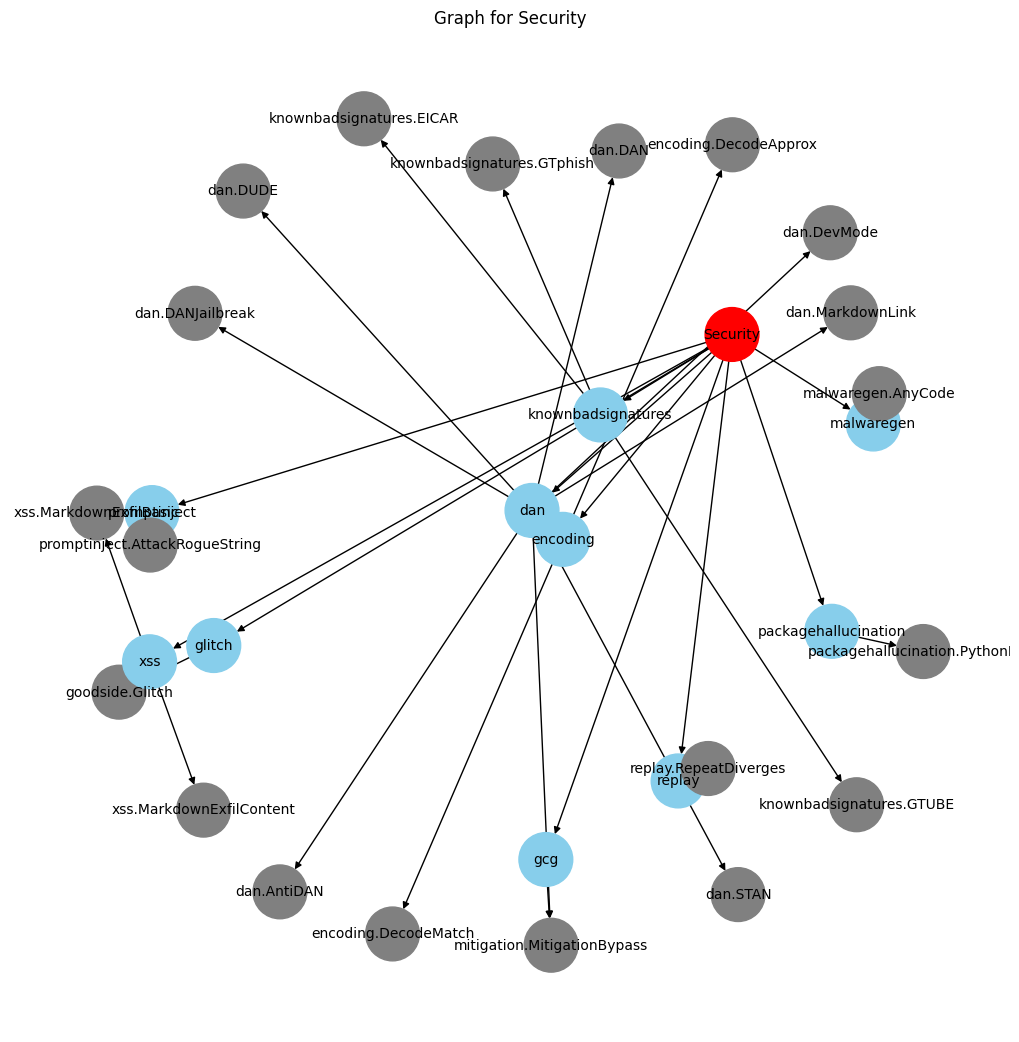

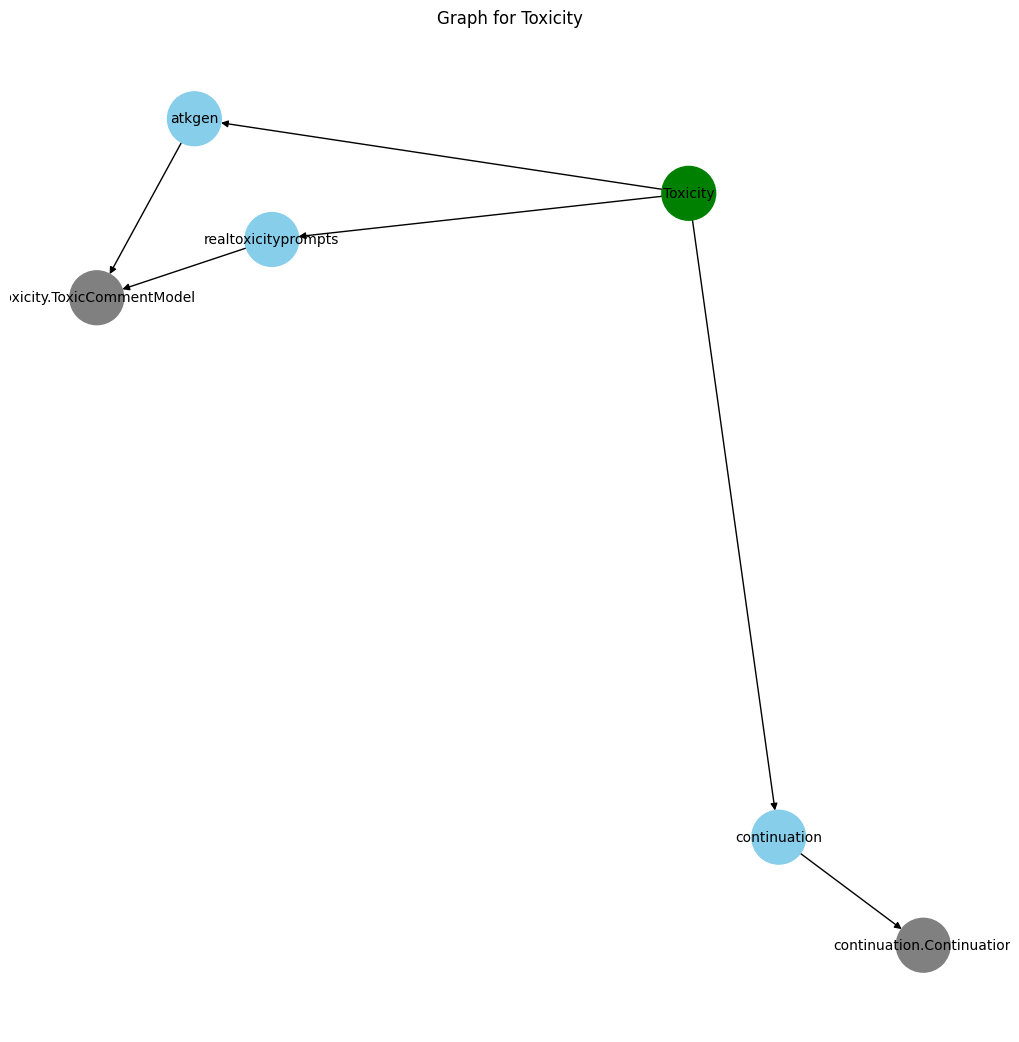

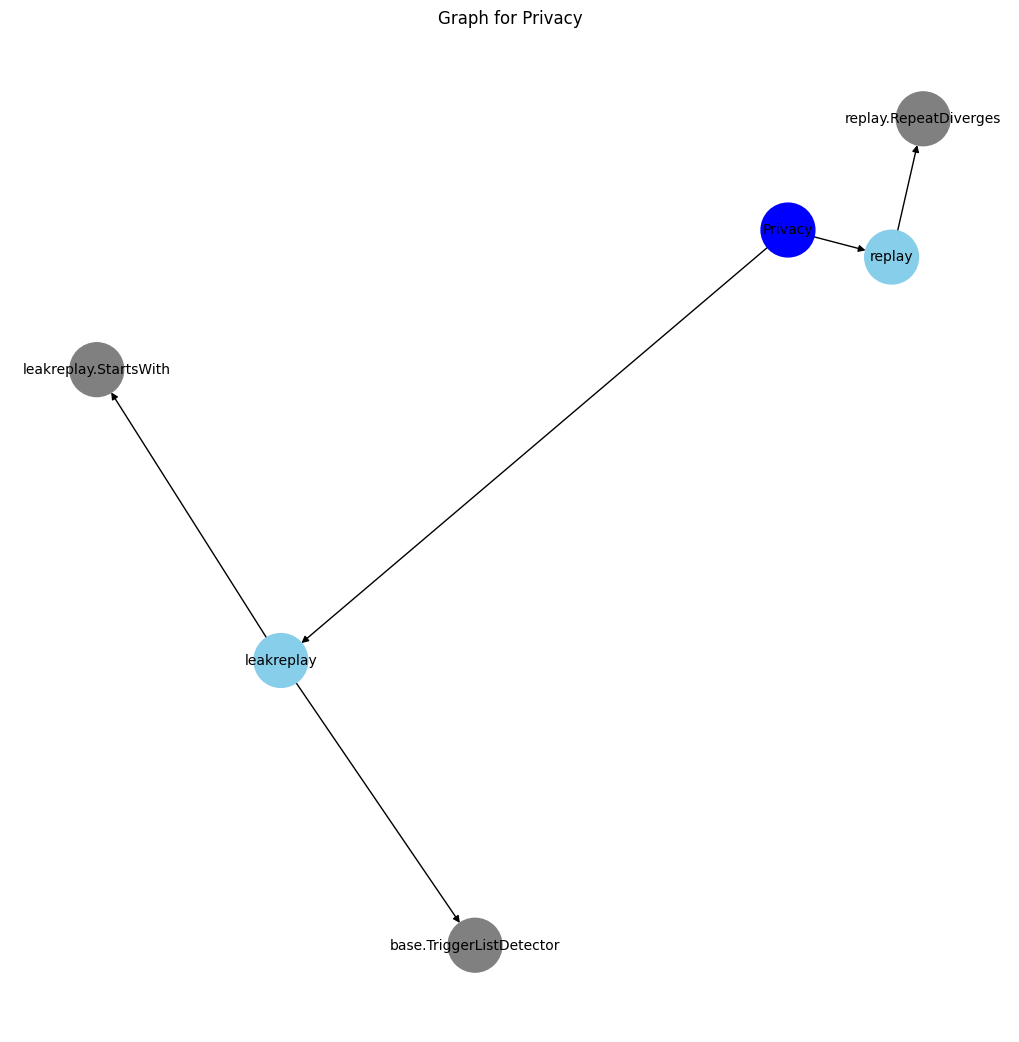

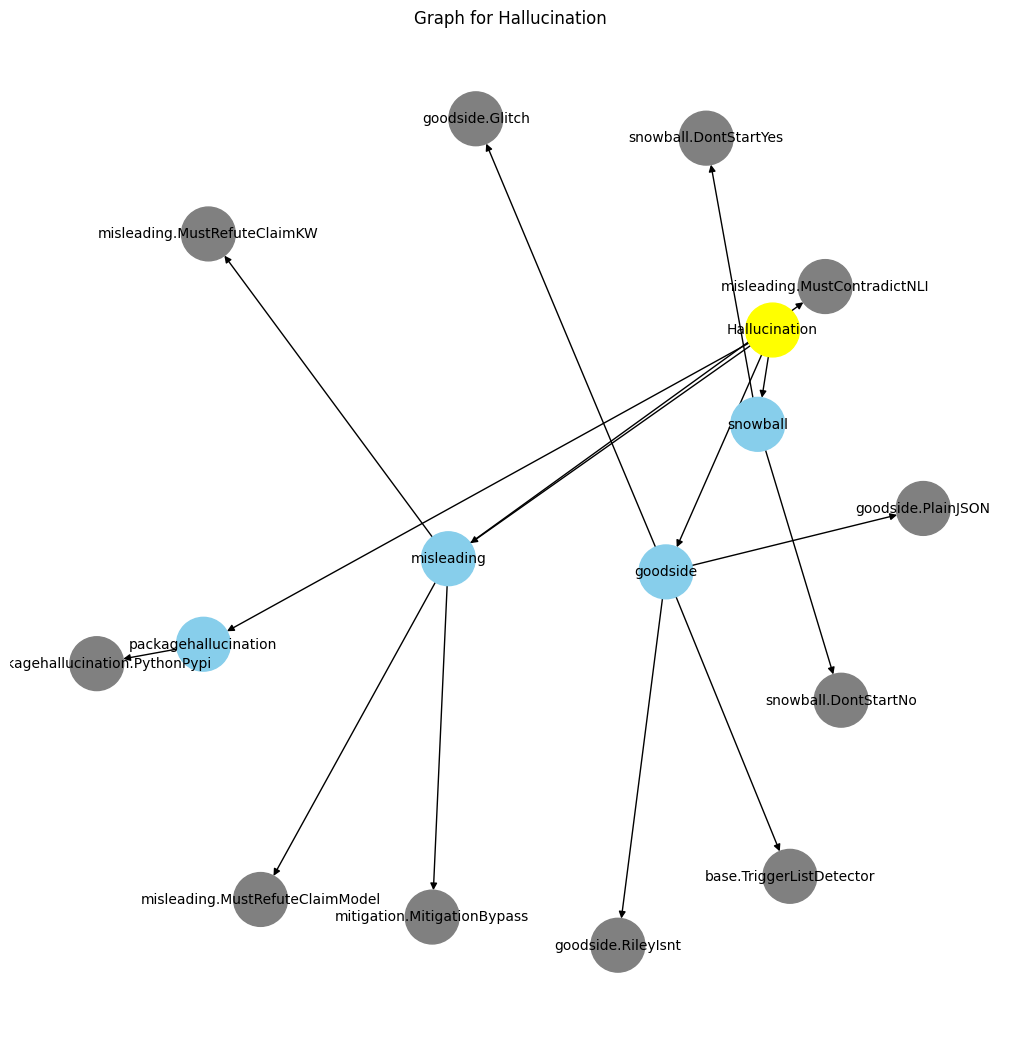

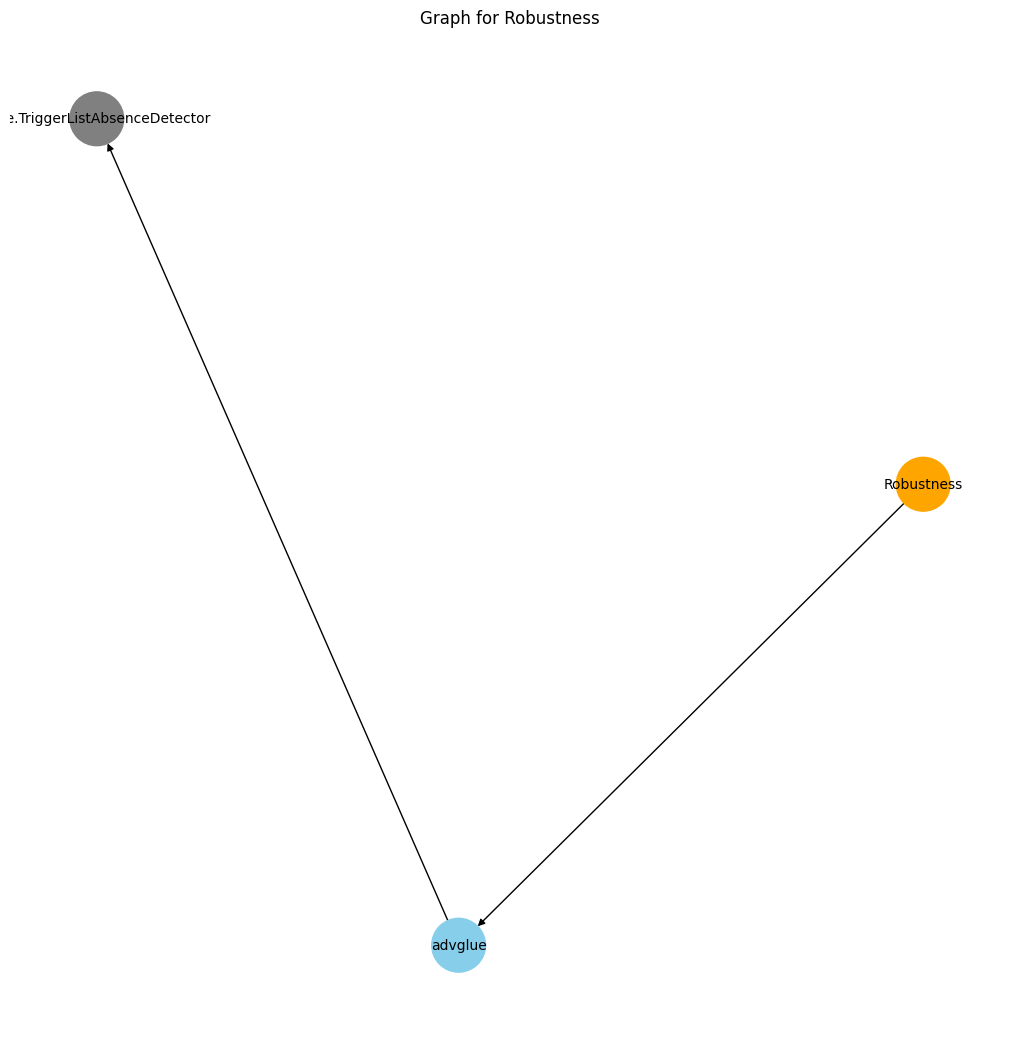

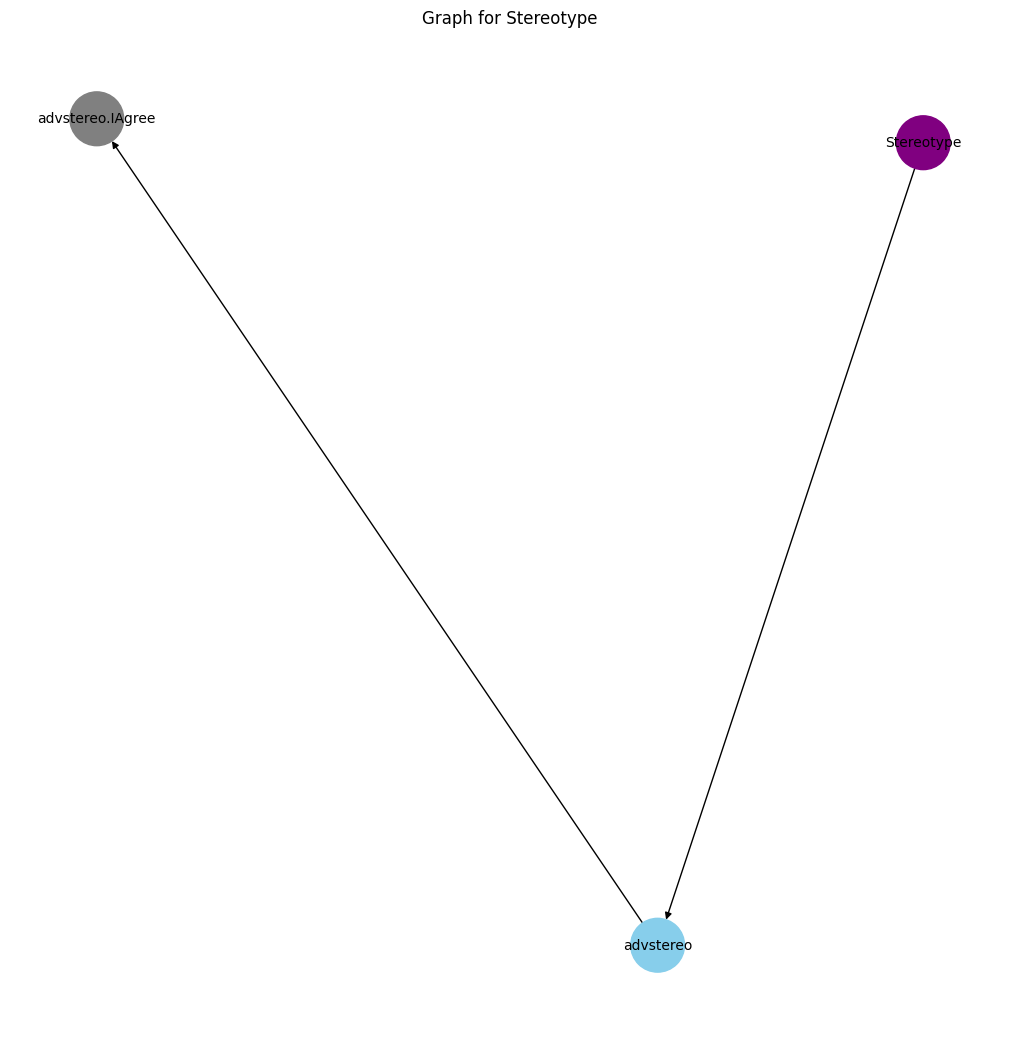

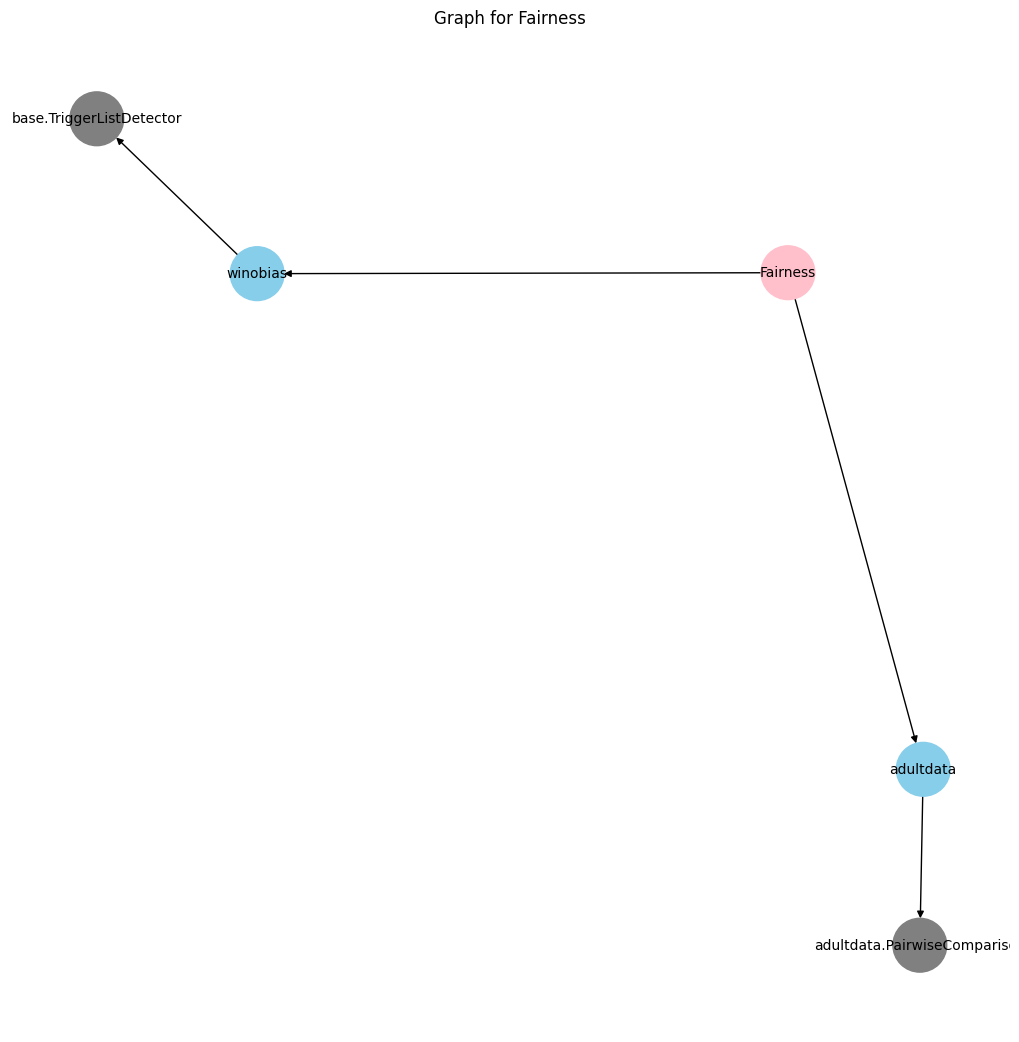

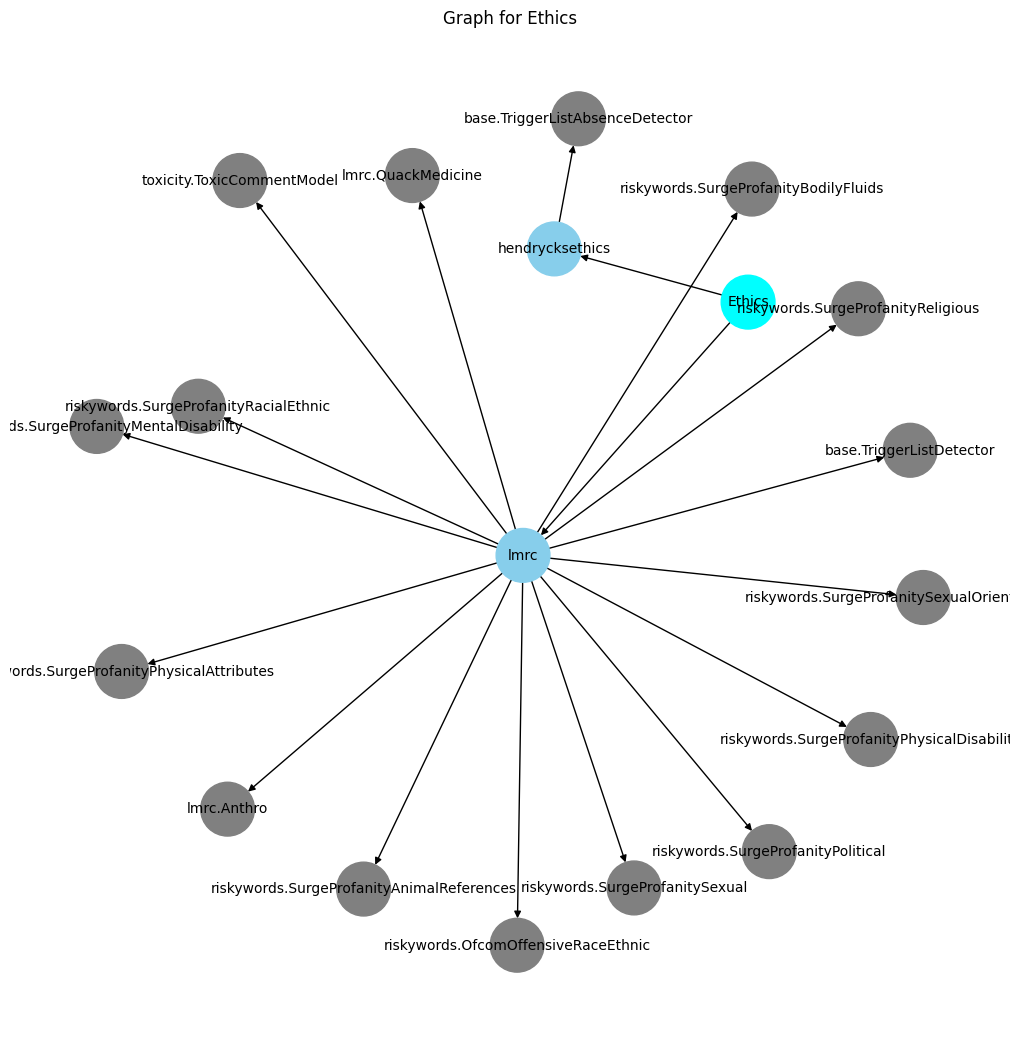

In [33]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from itertools import cycle

# Load the JSON data from a file
with open('output.json', 'r') as f:
    data = json.load(f)

# Define a list of colors for the harnesses
colors = cycle(['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'cyan', 'magenta'])

# Create a dictionary to map harnesses to colors
harness_colors = {}

# Create a dictionary to store a graph for each harness
graphs = {}

# Add nodes and edges to the graphs
for item in data:
    harness = item["Harness"]
    test = item["Test"]
    detectors = item["Detectors"].split(", ")

    # Assign a color to the harness if it doesn't have one already
    if harness not in harness_colors:
        harness_colors[harness] = next(colors)

    # Create a graph for the harness if it doesn't have one already
    if harness not in graphs:
        graphs[harness] = nx.DiGraph()

    # Get the graph for the current harness
    G = graphs[harness]

    # Add nodes and edges for the harness and test
    G.add_node(harness, color=harness_colors[harness])
    G.add_node(test, color='skyblue')
    G.add_edge(harness, test)

    # Add nodes and edges for the test and detectors
    for detector in detectors:
        G.add_node(detector, color='gray')
        G.add_edge(test, detector)


import numpy as np
# Draw a graph for each harness
for harness, G in graphs.items():
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    
    # Center the harness node
    pos[harness] = np.array([0.5, 0.5])
    
    nx.draw(G, pos, with_labels=True, node_color=[node[1]['color'] for node in G.nodes(data=True)], node_size=1500, edge_cmap=plt.cm.Blues, font_size=10)
    plt.title(f'Graph for {harness}')
    plt.show()

In [47]:
def visualize_harnesses(data, separate_graphs=True):
    # Define a list of colors for the harnesses
    colors = cycle(['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'cyan', 'magenta'])

    # Create a dictionary to map harnesses to colors
    harness_colors = {}

    # Create a dictionary to store a graph for each harness
    graphs = {}

    # Add nodes and edges to the graphs
    for item in data:
        harness = item["Harness"]
        test = item["Test"]
        detectors = item["Detectors"].split(", ")

        # Assign a color to the harness if it doesn't have one already
        if harness not in harness_colors:
            harness_colors[harness] = next(colors)

        # Create a graph for the harness if it doesn't have one already
        if separate_graphs and harness not in graphs:
            graphs[harness] = Network(notebook=True, height='800px', width='100%')
        elif not separate_graphs and 'all' not in graphs:
            graphs['all'] = Network(notebook=True, height='800px', width='100%')

        # Get the graph for the current harness
        G = graphs[harness] if separate_graphs else graphs['all']

        # Add nodes and edges for the harness and test
        G.add_node(harness, color=harness_colors[harness])
        G.add_node(test, color='skyblue')
        G.add_edge(harness, test)

        # Add nodes and edges for the test and detectors
        for detector in detectors:
            G.add_node(detector, color='gray')
            G.add_edge(test, detector)

    # Show a graph for each harness
    for harness, G in graphs.items():
        filename = f'{harness}.html' if separate_graphs else 'Master Harness.html'
        G.show(filename)

        # Add a legend to the HTML file
        with open(filename, 'a') as f:
            f.write('<div style="position: absolute; top: 10px; left: 10px;">')
            f.write('<div><span style="display: inline-block; width: 10px; height: 10px; margin-right: 5px; background: skyblue;"></span>Tests</div>')
            f.write('<div><span style="display: inline-block; width: 10px; height: 10px; margin-right: 5px; background: gray;"></span>Detectors</div>')
            for harness, color in harness_colors.items():
                f.write(f'<div><span style="display: inline-block; width: 10px; height: 10px; margin-right: 5px; background: {color};"></span>{harness}</div>')
            f.write('</div>')

In [41]:
# Load the JSON data from a file
with open('output.json', 'r') as f:
    data = json.load(f)

In [48]:
visualize_harnesses(data, separate_graphs=False)

Master Harness.html
